In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [3]:
y = df.pop('Exited')

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=1234)

In [5]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    

class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [6]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [7]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    
    final_transformers.append((cont_col, cont_transformer))

In [8]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [10]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
pipeline1 = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(random_state=42)),
])

pipeline1.fit(X_train, y_train)
preds1 = pipeline1.predict_proba(X_test)[:, 1]

precision, recall, thresholds1 = precision_recall_curve(y_test, preds1)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds1[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.3072333069642994, F-Score=0.629, Precision=0.641, Recall=0.617


Confusion matrix, without normalization
[[1818  175]
 [ 195  312]]


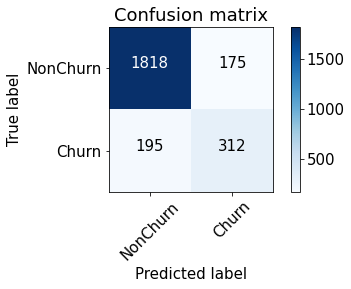

In [11]:
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds1 > thresholds1[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.show()

In [12]:
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]


retain_sum = (FP + TP) * 1
income = TP * 2

income - retain_sum

137

In [13]:
pipeline2 = Pipeline([
    ('features', feats),
    ('classifier', CatBoostClassifier(silent=True, random_state=42)),
])

pipeline2.fit(X_train, y_train)
preds2 = pipeline2.predict_proba(X_test)[:, 1]

precision, recall, thresholds2 = precision_recall_curve(y_test, preds2)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds2[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.23246643847705775, F-Score=0.625, Precision=0.563, Recall=0.702


Confusion matrix, without normalization
[[1717  276]
 [ 152  355]]


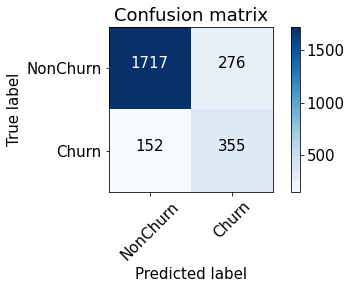

In [14]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds2 > thresholds2[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.show()

In [15]:
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]


retain_sum = (FP + TP) * 1
income = TP * 2

income - retain_sum

79

In [16]:
pipeline3 = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(random_state=42)),
])

pipeline3.fit(X_train, y_train)
preds3 = pipeline3.predict_proba(X_test)[:, 1]

precision, recall, thresholds3 = precision_recall_curve(y_test, preds3)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds3[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.19896555797339313, F-Score=0.406, Precision=0.295, Recall=0.651


Confusion matrix, without normalization
[[1204  789]
 [ 178  329]]


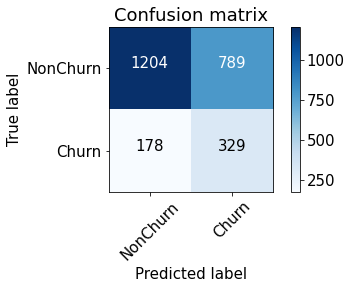

In [17]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds3 > thresholds3[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.show()

In [18]:
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]


retain_sum = (FP + TP) * 1
income = TP * 2

income - retain_sum

-460

In [ ]:
from sklearn.model_selection import GridSearchCV

In [22]:
%%time
params = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_features':[0.3, 0.5, 0.7],
    'classifier__min_samples_leaf':[2, 3]
}

grid = GridSearchCV(pipeline1,
                    param_grid=params,
                    cv=6,
                    refit=False,
                    verbose=3)

search = grid.fit(X_train, y_train)
search.best_params_

Fitting 6 folds for each of 12 candidates, totalling 72 fits
[CV 1/6] END classifier__max_features=0.3, classifier__min_samples_leaf=2, classifier__n_estimators=100; total time=   0.2s
[CV 2/6] END classifier__max_features=0.3, classifier__min_samples_leaf=2, classifier__n_estimators=100; total time=   0.2s
[CV 3/6] END classifier__max_features=0.3, classifier__min_samples_leaf=2, classifier__n_estimators=100; total time=   0.2s
[CV 4/6] END classifier__max_features=0.3, classifier__min_samples_leaf=2, classifier__n_estimators=100; total time=   0.2s
[CV 5/6] END classifier__max_features=0.3, classifier__min_samples_leaf=2, classifier__n_estimators=100; total time=   0.2s
[CV 6/6] END classifier__max_features=0.3, classifier__min_samples_leaf=2, classifier__n_estimators=100; total time=   0.2s
[CV 1/6] END classifier__max_features=0.3, classifier__min_samples_leaf=2, classifier__n_estimators=200; total time=   0.5s
[CV 2/6] END classifier__max_features=0.3, classifier__min_samples_leaf

{'classifier__max_features': 0.7,
 'classifier__min_samples_leaf': 3,
 'classifier__n_estimators': 200}

In [23]:
pipeline = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(n_estimators=200, max_features=0.7, 
                                          min_samples_leaf=3, random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

Best Threshold=0.32313093010309585, F-Score=0.629, Precision=0.651, Recall=0.607
Confusion matrix, without normalization
[[1828  165]
 [ 200  307]]


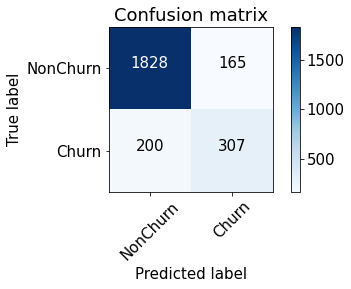

In [24]:
preds = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.show()

In [25]:
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]


retain_sum = (FP + TP) * 1
income = TP * 2

income - retain_sum

142

**Градиентный бустинг победил. Без настройки гипрепараметров получаем 137 долларов, с настройкой 142**